## Benchmark 6 revisit: linear models with structured bootstrap resampling
OK, so first round of linear model submissions to the public leaderboard produced some concerning results. TLDR: control resampling distribution seems to predict public leaderboard result well, linear models do not. Bootstrapping result look as if both Seigel and Theil-Sen regression will beat naive control with high probability, but both receive low scores that are extremely unlikely given their observed bootstrapped score distributions. What's going on? Let's try and find out - first thing is to check every step by manually inspecting output for sanity.

Note: this is version 2 of this notebook, version 1 was preserved in the state which produced the suspect results under investigation for reference.

While we are at it, let's start a major refactor here and move away from using notebooks for our main data generating logic and functions and instead use them just for plotting and discussion.

1. [Abbreviations & definitions](#abbrevations_definitions)
2. [Results](#results)

<a name="abbreviations_definitions"></a>
### 1. Abbreviations & definitions
+ MBD: microbusiness density
+ MBC: microbusiness count
+ OLS: ordinary least squares
+ Model order: number of past timepoints used as input data for model training
+ Origin (forecast origin): last known point in the input data
+ Horizon (forecast horizon): number of future data points predicted by the model
+ SMAPE: Symmetric mean absolute percentage error

In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.parallelization_functions as parallel_funcs

paths = conf.DataFilePaths()
params = conf.LinearModelsBootstrappingParameters()

import statistics
import multiprocessing as mp
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statistics import NormalDist

<a name="results"></a>
### 2. Results

In [2]:
# Load and inspect results - each row is an individual datapoint from one of the conditions/samples
input_file = f'{paths.BOOTSTRAPPING_RESULTS_PATH}/{params.output_file_root_name}.parquet'
data_df = pd.read_parquet(input_file)
data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.007134,0.007010,1.197231,1.180416,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
1,0,OLS,4,0.016566,0.010621,1.208577,1.176161,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
2,0,TS,4,0.013222,0.014331,1.204542,1.171805,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
3,0,Seigel,4,0.010597,0.018923,1.201384,1.166437,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
4,0,Ridge,4,0.016056,0.007232,1.207961,1.180154,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872


In [3]:
# Calculate the final SMAPE score for each sample in each condition
sample_smape_scores_df = data_df.groupby(['sample', 'model_type', 'model_order'])[['SMAPE_values', 'detrended_SMAPE_values']].mean().mul(100)

# Rename columns to reflect the change from SMAPE values for a single prediction to
# SMAPE scores within a sample
sample_smape_scores_df.rename(inplace=True, columns={'SMAPE_values': 'SMAPE_score', 'detrended_SMAPE_values': 'detrended_SMAPE_score'})

# Clean up index and inspect. Now each sample in all of the conditions is represented by a single row
# with two SMAPE scores calculated from all of the datapoints in that condition and sample. One from
# the fit and forecast on the raw data and the other from the fit and forecast on the difference
# detrended data
sample_smape_scores_df.reset_index(inplace=True, drop=False)
sample_smape_scores_df.head()

,sample,model_type,model_order,SMAPE_score,detrended_SMAPE_score
0,0,OLS,4,3.429214,3.966415
1,0,OLS,8,3.482866,2.968860
2,0,OLS,16,5.687728,2.977525
3,0,OLS,32,6.127524,2.600077
4,0,Ridge,4,3.204490,3.703140


OK, let's take a look! Going to use a boxplot to look at the distribution of sample SMAPE scores across the different models and model orders. We also have fits to the raw and detrended data to look at. Keep in mind that the detrended fit was used to generate a raw MBD value for scoring purposes, so the underlying scale of the raw and detrended data panels are the same.

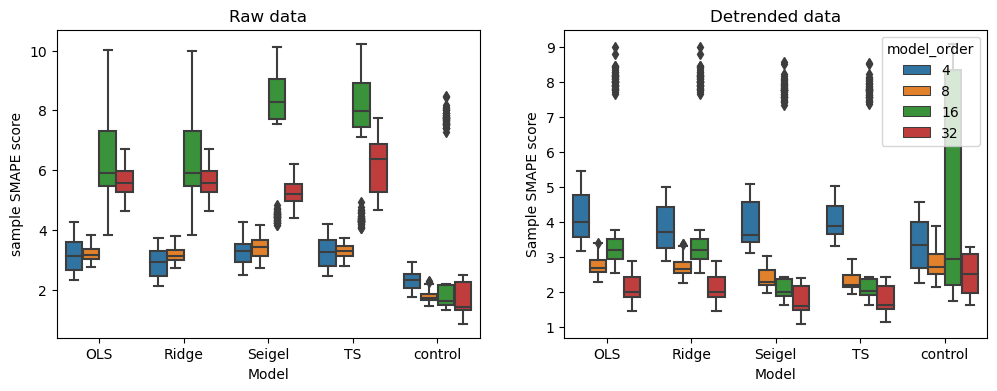

In [4]:
fig, ax = plt.subplots(1, 2,figsize=(12,4))

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='SMAPE_score',
    hue='model_order',
    ax=ax[0]
)

ax[0].set(
    xlabel='Model', 
    ylabel='sample SMAPE score', 
    title='Raw data'
)
        # Collect detrended model forecast
ax[0].get_legend().remove()

sns.boxplot(
    data=sample_smape_scores_df, 
    x='model_type',
    y='detrended_SMAPE_score',
    hue='model_order',
    ax=ax[1]
)

ax[1].set(
    xlabel='Model', 
    ylabel='Sample SMAPE score', 
    title='Detrended data'
)

plt.show()

Now, let's compare another way by plotting individual SMAPE values for all the datapoints in control vs regression.


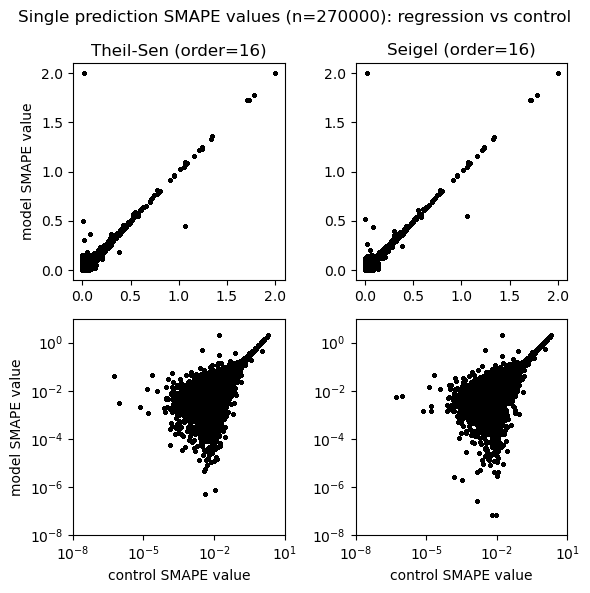

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[0,0].set_ylabel('model SMAPE value')
ax[0,0].set_title('Theil-Sen (order=16)')

ax[0,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[0,1].set_title('Seigel (order=16)')

ax[1,0].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('control SMAPE value')
ax[1,0].set_ylabel('model SMAPE value')
ax[1,0].set_xlim([10**-8,10])
ax[1,0].set_ylim([10**-8,10])

ax[1,1].scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 16)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('control SMAPE value')
ax[1,1].set_xlim([10**-8,10])
ax[1,1].set_ylim([10**-8,10])

n = len(data_df[(data_df['model_type'] == 'TS') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): regression vs control')
plt.tight_layout()

Let's take a closer look at our winner(s).

In [6]:
# Aggregate scores again, this time averaging all of the samples in each condition so we have one datapoint for each model and order
mean_sample_smape_score_df = sample_smape_scores_df.groupby(['model_type', 'model_order'])[['SMAPE_score', 'detrended_SMAPE_score']].mean()

# Rename columns to reflect new value
mean_sample_smape_score_df.rename(inplace=True, columns={'SMAPE_score': 'mean_SMAPE_score', 'detrended_SMAPE_score': 'mean_detrended_SMAPE_score'})

# Clean up and inspect
mean_sample_smape_score_df.reset_index(inplace=True, drop=False)
mean_sample_smape_score_df.head()

,model_type,model_order,mean_SMAPE_score,mean_detrended_SMAPE_score
0,OLS,4,3.145217,4.158557
1,OLS,8,3.194741,2.738548
2,OLS,16,6.417398,4.172909
3,OLS,32,5.622215,2.080083
4,Ridge,4,2.876339,3.835929


In [7]:
# Get top 10 models by mean detrended SMAPE score
detrended_top_10 = mean_sample_smape_score_df.sort_values(by=['mean_detrended_SMAPE_score']).head(10)

# Get winner type and order
winning_model_type = detrended_top_10['model_type'].to_list()[0]
winning_model_order = detrended_top_10['model_order'].to_list()[0]

# Get raw data for winner
winner = data_df[(data_df['model_type'] == winning_model_type) & (data_df['model_order'] == winning_model_order)]

# Get raw data for sample matched control
control = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == winning_model_order)]

# Inspect
control.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
22500,0,control,32,0.042553,0.086956,1.669086,1.596517,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655
22505,0,control,32,0.007722,0.007663,1.205044,1.223727,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386
22510,0,control,32,0.016584,0.006557,3.064781,3.136532,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031


In [8]:
winner.head(3)

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
22503,0,Seigel,32,0.280631,0.042553,2.310191,1.669086,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655
22508,0,Seigel,32,0.037810,0.005466,1.169322,1.207765,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386
22513,0,Seigel,32,0.015627,0.006964,3.067713,3.137806,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031


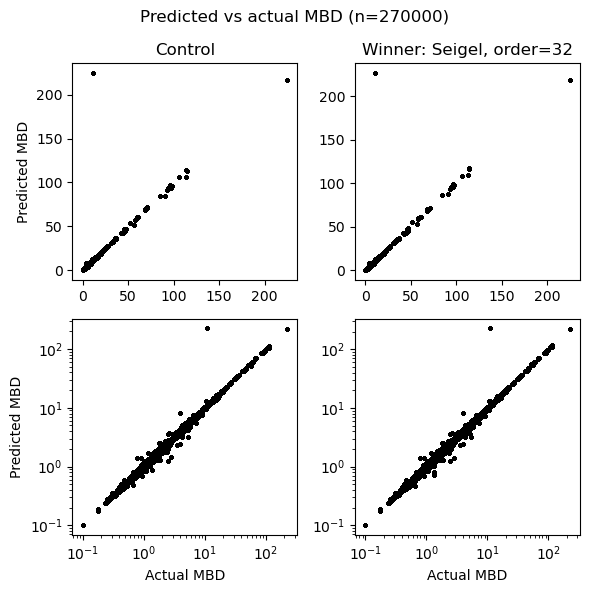

In [9]:
# Plot true vs predicted values
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions'],
    color='black',
    s=4
)

ax[0,0].set_ylabel('Predicted MBD')
ax[0,0].set_title('Control')

ax[0,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions'],
    color='black',
    s=4
)

ax[0,1].set_title(f'Winner: {winning_model_type}, order={winning_model_order}')

ax[1,0].scatter(
    control['MBD_actual'],
    control['MBD_predictions'],
    color='black',
    s=4
)

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')

ax[1,0].set_xlabel('Actual MBD')
ax[1,0].set_ylabel('Predicted MBD')

ax[1,1].scatter(
    winner['MBD_actual'],
    winner['detrended_MBD_predictions'],
    color='black',
    s=4
)

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')

ax[1,1].set_xlabel('Actual MBD')

n = len(winner['MBD_actual'])
plt.suptitle(f'Predicted vs actual MBD (n={n})')
plt.tight_layout()

In [10]:
control_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == 'control') & (sample_smape_scores_df['model_order'] == winning_model_order)]
control_sample_smape_scores['SMAPE_score'].describe()

count    180.000000
mean       1.561848
std        0.521477
min        0.855174
25%        1.317946
50%        1.429338
75%        2.244805
max        2.500029
Name: SMAPE_score, dtype: float64

In [11]:
winner_sample_smape_scores = sample_smape_scores_df[(sample_smape_scores_df['model_type'] == winning_model_type) & (sample_smape_scores_df['model_order'] == winning_model_order)]
winner_sample_smape_scores['detrended_SMAPE_score'].describe()

count    180.000000
mean       1.664899
std        0.401164
min        1.089781
25%        1.495770
50%        1.595519
75%        2.172901
max        2.394467
Name: detrended_SMAPE_score, dtype: float64

In [12]:
t_test = stats.ttest_ind(winner_sample_smape_scores['detrended_SMAPE_score'], control_sample_smape_scores['SMAPE_score'])
print(f't-test p-value (H0: control mean = regression mean): {t_test[1]:.3e}')

t-test p-value (H0: control mean = regression mean): 3.630e-02


In [13]:

cm = sms.CompareMeans(sms.DescrStatsW(winner_sample_smape_scores['detrended_SMAPE_score']), sms.DescrStatsW(control_sample_smape_scores['SMAPE_score']))
ci = cm.tconfint_diff(usevar='unequal')
print(f'95% C.I. around difference in means: {ci[0]:.4f}, {ci[1]:.3f}')

95% C.I. around difference in means: 0.0066, 0.200


In [14]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Mean: {smape_mean:.3f}')
print(f'Standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Mean: 1.665
Standard deviation: 0.4000

Probability of SMAPE <= 1.0936: 0.077
Probability of SMAPE > 1.0936: 0.923


OK, unfortunately - this is more like the answer we should be getting.The winning model performs worse than the control on average, but not by much.  The control and winning distributions are definitely different. The difference, though small, is highly statistically significant because of the large sample sizes involved.

Let's check the probabilities of the observed leaderboard results before we move on to try and improve the result.

In [15]:
smape_mean = statistics.mean(winner_sample_smape_scores['detrended_SMAPE_score'])
smape_std = statistics.pstdev(winner_sample_smape_scores['detrended_SMAPE_score'])

print(f'Winner mean: {smape_mean:.3f}')
print(f'Winner standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.2027)
print(f'Probability of model SMAPE <= 1.2027: {leaderboard_score_probability:.3f}')
print(f'Probability of model SMAPE > 1.2027: {1 - leaderboard_score_probability:.3f}')

Winner mean: 1.665
Winner standard deviation: 0.4000

Probability of model SMAPE <= 1.2027: 0.124
Probability of model SMAPE > 1.2027: 0.876


In [16]:
smape_mean = statistics.mean(control_sample_smape_scores['SMAPE_score'])
smape_std = statistics.pstdev(control_sample_smape_scores['SMAPE_score'])

print(f'Control mean: {smape_mean:.3f}')
print(f'Control standard deviation: {smape_std:.4f}')
print()

leaderboard_score_probability = NormalDist(mu=smape_mean, sigma=smape_std).cdf(1.0936)
print(f'Probability of control SMAPE <= 1.0936: {leaderboard_score_probability:.3f}')
print(f'Probability of control SMAPE > 1.0936: {1 - leaderboard_score_probability:.3f}')

Control mean: 1.562
Control standard deviation: 0.5200

Probability of control SMAPE <= 1.0936: 0.184
Probability of control SMAPE > 1.0936: 0.816


Interesting - both observed scores split the sampling distribution at approximately the same place. A pretty good showing on the leaderboard for both ~3 in 20 chance shot to do as well or better than observed for both.

Problem is, we are still loosing. On the bright side - we now can get a much better handle on the expected leaderboard results looking at our internal bootstrapping benchmark.

I am still tantalized by the observation that for some datapoints the control does well and the regression model does poorly, while for other points the control does poorly and the regression model does well. If we could pick the right model based on the input data alone, I think we could improve our score a bit - and figuring out a good way to do that would be generally useful. We could used a mixed bagging approach were we fit with several different models and pick or weight the best one. Now that we have the bootstrapping figured out, let's give it one more shot.

For reference, here is the specific plot I am referring to:

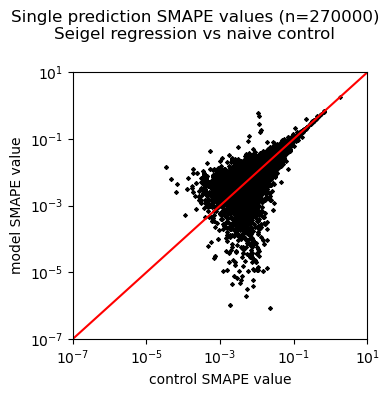

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 32)]['SMAPE_values'],
    data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)]['detrended_SMAPE_values'],
    color='black',
    s=2
)

ax.axline([0, 0], [1, 1], color='red')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('control SMAPE value')
ax.set_ylabel('model SMAPE value')
ax.set_xlim([10**-7,10])
ax.set_ylim([10**-7,10])


n = len(data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n})\nSeigel regression vs naive control')
plt.tight_layout()

Points along the y = x diagonal get a similar score with the control and regression models. Points above the diagonal score worse with the regression model than the control - in those cases we would rather take the control prediction. Points below the line score better with the regression model than the control - we would want to keep the regression value. Problem is, we need a way to classify points before we know their score, looking at the input data only. In notebook #11.1 we looked at the correlation of a bunch of one number 'summary' values derived from the input data with the SMAPE score and didn't find anything useful. I'm wondering if we should try looking at the difference between the model score and the control score and try to correlate that with some property of the input data. Let's get the score differences and just plot those to start with.  

In [18]:
model_data_df = data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)].copy()
model_data_df.reset_index(inplace = True, drop=True)

control_data_df = data_df[(data_df['model_type'] == 'control') & (data_df['model_order'] == 32)].copy()
control_data_df.reset_index(inplace=True, drop=True)

In [19]:
model_data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,Seigel,32,0.280631,0.042553,2.310191,1.669086,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655
1,0,Seigel,32,0.037810,0.005466,1.169322,1.207765,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386
2,0,Seigel,32,0.015627,0.006964,3.067713,3.137806,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031
3,0,Seigel,32,0.031594,0.021617,1.244452,1.232096,"[1.1312218, 1.1060835, 1.1252813, 1.0752689, 1...","[-0.10055299999999989, -0.025138300000000058, ...",1.205747
4,0,Seigel,32,0.025929,0.035714,1.728645,1.625296,"[1.2269939, 1.2269939, 1.2099214, 1.2401694, 1...","[0.0, 0.0, -0.017072500000000046, 0.0302480000...",1.684397


In [20]:
model_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270000 entries, 0 to 269999
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   sample                     270000 non-null  int64  
 1   model_type                 270000 non-null  object 
 2   model_order                270000 non-null  int64  
 3   SMAPE_values               270000 non-null  float64
 4   detrended_SMAPE_values     270000 non-null  float64
 5   MBD_predictions            270000 non-null  float64
 6   detrended_MBD_predictions  270000 non-null  float64
 7   MBD_inputs                 270000 non-null  object 
 8   detrended_MBD_inputs       270000 non-null  object 
 9   MBD_actual                 270000 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 20.6+ MB


In [21]:
model_data_df['SMAPE_diff'] = (model_data_df['detrended_SMAPE_values'] - control_data_df['SMAPE_values']) / (control_data_df['SMAPE_values'] + model_data_df['detrended_SMAPE_values'])
model_data_df['prediction_diff'] = (model_data_df['detrended_MBD_predictions'] - control_data_df['MBD_predictions']) / (control_data_df['MBD_predictions'] + model_data_df['detrended_MBD_predictions'])
model_data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual,SMAPE_diff,prediction_diff
0,0,Seigel,32,0.280631,0.042553,2.310191,1.669086,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655,0.000000,0.000000
1,0,Seigel,32,0.037810,0.005466,1.169322,1.207765,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386,-0.171015,0.001128
2,0,Seigel,32,0.015627,0.006964,3.067713,3.137806,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031,-0.408537,0.011773
3,0,Seigel,32,0.031594,0.021617,1.244452,1.232096,"[1.1312218, 1.1060835, 1.1252813, 1.0752689, 1...","[-0.10055299999999989, -0.025138300000000058, ...",1.205747,0.013229,0.000282
4,0,Seigel,32,0.025929,0.035714,1.728645,1.625296,"[1.2269939, 1.2269939, 1.2099214, 1.2401694, 1...","[0.0, 0.0, -0.017072500000000046, 0.0302480000...",1.684397,0.000000,0.000000


In [22]:
model_data_df['SMAPE_diff'].describe()

count    256316.000000
mean          0.073511
std           0.387012
min          -0.999923
25%          -0.096304
50%           0.001179
75%           0.227600
max           1.000000
Name: SMAPE_diff, dtype: float64

In [23]:
model_data_df['prediction_diff'].describe()

count    269918.000000
mean          0.000781
std           0.005794
min          -0.302486
25%          -0.000045
50%           0.000656
75%           0.002333
max           0.085762
Name: prediction_diff, dtype: float64

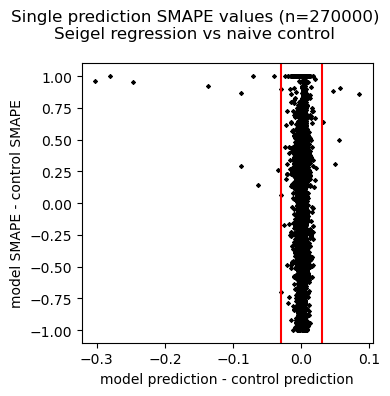

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    model_data_df['prediction_diff'],
    model_data_df['SMAPE_diff'],
    color='black',
    s=2
)

ax.axline([-0.03,-1.00], [-0.03,1.00], color='red')
ax.axline([0.03,-1.00], [0.03,1.00], color='red')

ax.set_xlabel('model prediction - control prediction')
ax.set_ylabel('model SMAPE - control SMAPE')

#ax.set_xscale('log', base=2)

n = len(data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n})\nSeigel regression vs naive control')
plt.tight_layout()

Ok, I think we might be on to something: if model - control SMAPE value is positive then the model SMAPE was higher (worse) than the control - so the top half of the plot. For model - control prediction < -0.035 and > 0.035, all of the points are in the top half! This means that if the difference in the result we get from the control and the model is outside of those bounds, we will do better taking the control value. Don't get to excited - it looks like it may be a pretty small fraction of the total points, but it's something. Let's add some bounding lines ot the plot for illustrative purposes and then see how many points we are talking about.

Also, does it seem like a strange coincidence that the upper and lower bounds occur at about the same value? I wonder if we could move the limits in a bit and still benefit, even though we might start tossing some 'good' points out with the bath water.

In [25]:
control_wins = model_data_df[(model_data_df['prediction_diff'] <= -0.03) | (model_data_df['prediction_diff'] >= 0.3)].copy()
print(f'{(len(control_wins) / len(model_data_df)) * 100:.3f}% of predictions out-of-bounds.')

0.090% of predictions out-of-bounds.


OK, so like I thought - tiny. Not sure if it would have any noticeable effect on the total score, but it couldn't hurt to fix some of our worst performing points. Let's try a few other things before we pack it up. Here comes the kitchen sink...

In [26]:
data_ranges = []
SMAPE_values = []
SMAPE_diff_values = []
theil_slopes = []
total_fit_residuals = []
mean_fit_residuals = []
total_residuals_as_fraction_of_range = []
mean_residuals_as_fraction_of_range = []
slope_range = []
input_variance = []
input_deviation = []
input_absolute_sum = []

for i in range(len(model_data_df)):

    # Get data for this row
    data_point = model_data_df.iloc[[i]]
    input_data = list(data_point['detrended_MBD_inputs'])[0]
    SMAPE_value = list(data_point['detrended_SMAPE_values'])[0]
    SMAPE_diff_value = list(data_point['SMAPE_diff'])[0]
    data_range = max(input_data) - min(input_data)

    if data_range != 0:

        # Collect absolute input sum
        absolute_sum = 0
        
        for data in input_data:
            absolute_sum += abs(data)

        input_absolute_sum.append(absolute_sum)

        # Collect input variance
        input_variance.append(statistics.variance(input_data))

        # Collect input standard deviation
        input_deviation.append(statistics.stdev(input_data))

        # Collect input data range
        data_ranges.append(data_range)

        # Collect SMAPE value
        SMAPE_values.append(SMAPE_value)
        SMAPE_diff_values.append(SMAPE_diff_value)

        # Fit Theil-Sen
        ts = stats.theilslopes(input_data, list(range(len(input_data))))

        # Recover slope and intercept
        slope = ts[0]
        intercept = ts[1]

        # Collect slope
        theil_slopes.append(slope)

        # Collect slope range
        slope_range.append(ts[3] - ts[2])

        # Sum fit residuals
        i = 0
        residuals = 0

        for input in input_data:
            model_y = intercept + slope * i
            residuals += abs(model_y - input)
            i += 1

        total_fit_residuals.append(residuals)
        mean_fit_residuals.append(residuals / len(input_data))

        total_residuals_as_fraction_of_range.append(residuals / data_range)
        mean_residuals_as_fraction_of_range.append((residuals / len(input_data)) / data_range)

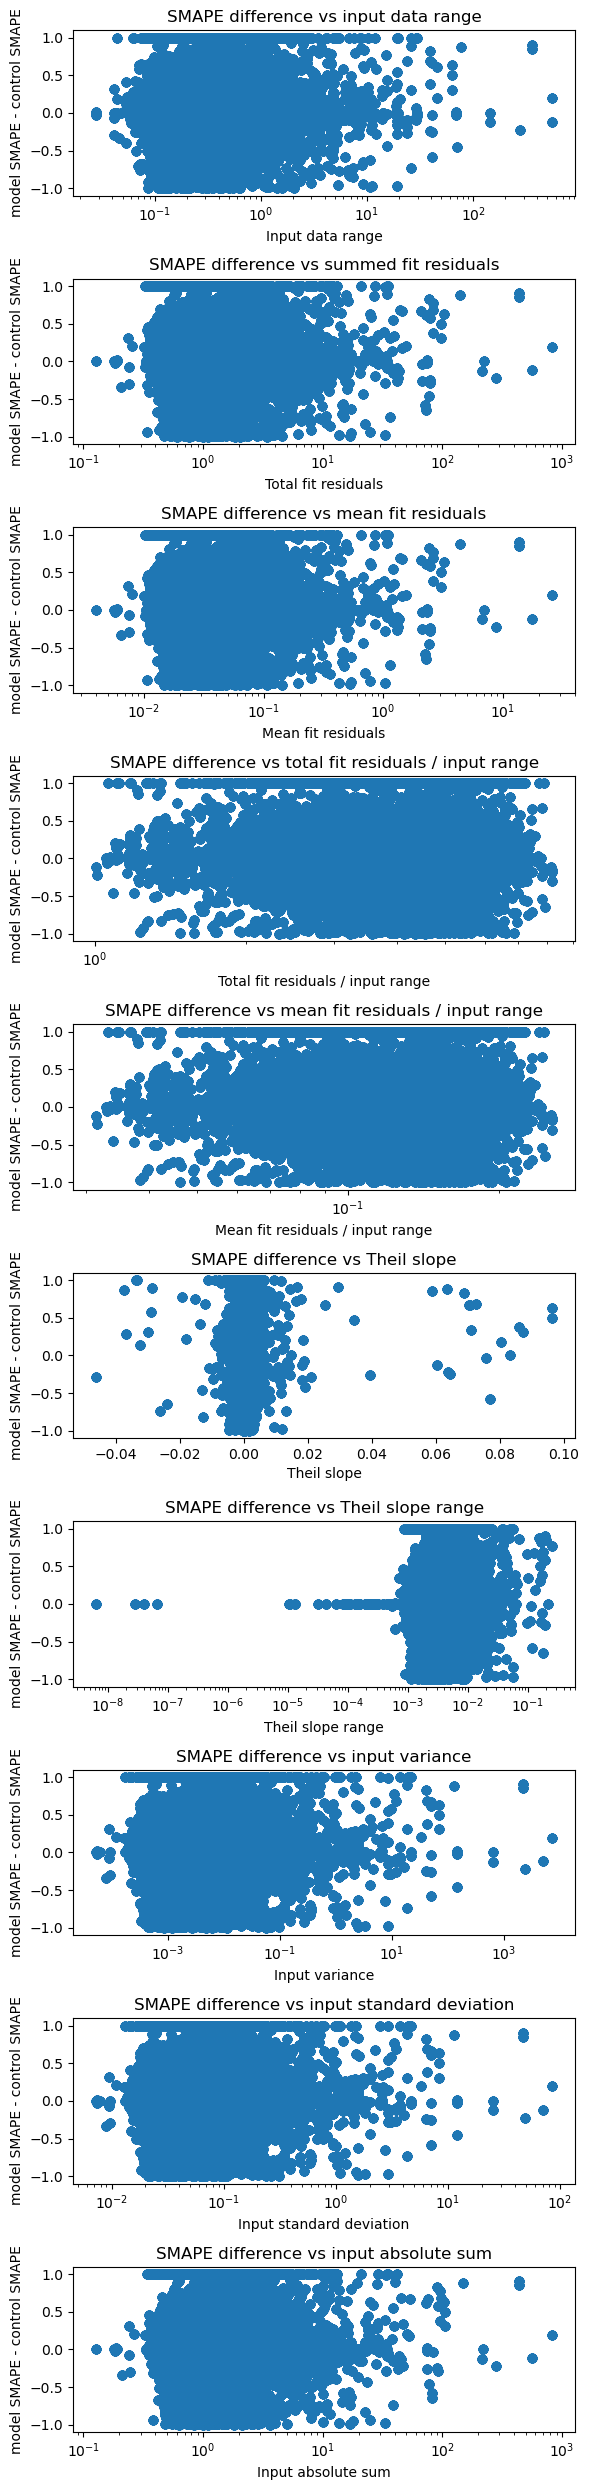

In [27]:
fig, ax = plt.subplots(10, 1, figsize=(6,25))

ax[0].scatter(
    data_ranges,
    SMAPE_diff_values
)
ax[0].set_xlabel('Input data range')
ax[0].set_ylabel('model SMAPE - control SMAPE')
ax[0].title.set_text('SMAPE difference vs input data range')
ax[0].set_xscale('log', base=10)

ax[1].scatter(
    total_fit_residuals,
    SMAPE_diff_values
)
ax[1].set_xlabel(f'Total fit residuals')
ax[1].set_ylabel(f'model SMAPE - control SMAPE')
ax[1].title.set_text('SMAPE difference vs summed fit residuals')
ax[1].set_xscale('log', base=10)

ax[2].scatter(
    mean_fit_residuals,
    SMAPE_diff_values
)
ax[2].set_xlabel(f'Mean fit residuals')
ax[2].set_ylabel(f'model SMAPE - control SMAPE')
ax[2].title.set_text('SMAPE difference vs mean fit residuals')
ax[2].set_xscale('log', base=10)

ax[3].scatter(
    total_residuals_as_fraction_of_range,
    SMAPE_diff_values
)
ax[3].set_xlabel(f'Total fit residuals / input range')
ax[3].set_ylabel(f'model SMAPE - control SMAPE')
ax[3].title.set_text('SMAPE difference vs total fit residuals / input range')
ax[3].set_xscale('log', base=10)

ax[4].scatter(
    mean_residuals_as_fraction_of_range,
    SMAPE_diff_values
)
ax[4].set_xlabel(f'Mean fit residuals / input range')
ax[4].set_ylabel(f'model SMAPE - control SMAPE')
ax[4].title.set_text('SMAPE difference vs mean fit residuals / input range')
ax[4].set_xscale('log', base=10)

ax[5].scatter(
    theil_slopes,
    SMAPE_diff_values
)
ax[5].set_xlabel(f'Theil slope')
ax[5].set_ylabel(f'model SMAPE - control SMAPE')
ax[5].title.set_text('SMAPE difference vs Theil slope')
ax[3].set_xscale('log', base=10)

ax[6].scatter(
    slope_range,
    SMAPE_diff_values
)
ax[6].set_xlabel(f'Theil slope range')
ax[6].set_ylabel(f'model SMAPE - control SMAPE')
ax[6].title.set_text('SMAPE difference vs Theil slope range')
ax[6].set_xscale('log', base=10)

ax[7].scatter(
    input_variance,
    SMAPE_diff_values
)
ax[7].set_xlabel(f'Input variance')
ax[7].set_ylabel(f'model SMAPE - control SMAPE')
ax[7].title.set_text('SMAPE difference vs input variance')
ax[7].set_xscale('log', base=10)

ax[8].scatter(
    input_deviation,
    SMAPE_diff_values
)
ax[8].set_xlabel(f'Input standard deviation')
ax[8].set_ylabel(f'model SMAPE - control SMAPE')
ax[8].title.set_text('SMAPE difference vs input standard deviation')
ax[8].set_xscale('log', base=10)

ax[9].scatter(
    input_absolute_sum,
    SMAPE_diff_values
)
ax[9].set_xlabel(f'Input absolute sum')
ax[9].set_ylabel(f'model SMAPE - control SMAPE')
ax[9].title.set_text('SMAPE difference vs input absolute sum')
ax[9].set_xscale('log', base=10)

#plt.suptitle('Predicted vs actual MBD\nwinning regression model and control')
#plt.setp(ax, xlim=(-5,100), ylim=(-0.05,0.6))
plt.tight_layout()

OK, so in many of the above plots there is a line of points crowded at the top edge where model - control SMAPE = 1. To arrive at this value, the control SMAPE must have been zero, then the fraction used to normalize the SMAPE difference simplifies to model SMAPE / model SMAPE = 1. There MUST be some way to identify these points. Let's see if we can recover them. If we could take the control prediction in theses cases, we could probably improve our score significantly.

In [28]:
control_wins = model_data_df[model_data_df['SMAPE_diff'] == 1].copy()
print(f'{len(control_wins)} data points with normalized SMAPE diff. = 1.0')
print(f'{(len(control_wins) / len(model_data_df)) * 100:.3f}% of predictions have normalized SMAPE diff. = 1.0')

16490 data points with normalized SMAPE diff. = 1.0
6.107% of predictions have normalized SMAPE diff. = 1.0


In [29]:
model_wins = model_data_df[model_data_df['SMAPE_diff'] <= -0.9].copy()
print(f'{len(model_wins)} data points with normalized SMAPE diff. <= -0.9')
print(f'{(len(model_wins) / len(model_data_df)) * 100:.3f}% of predictions have normalized SMAPE diff. >= -0.9')

3376 data points with normalized SMAPE diff. <= -0.9
1.250% of predictions have normalized SMAPE diff. >= -0.9


This is on the order of 100x more data points than our last best idea. Let's go after it. Going to try just plotting the data to see if I can get and idea of what is going on to cause a bad regression fit, but a perfect control result.

In [30]:
model_wins.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual,SMAPE_diff,prediction_diff
80,0,Seigel,32,0.014816,0.000159,0.936363,0.922444,"[0.76281959, 0.74869335, 0.75627035, 0.7275512...","[0.009417539999999947, -0.014126239999999957, ...",0.922591,-0.942237,0.002601
158,0,Seigel,32,0.099989,0.000087,6.825769,7.543535,"[5.5261965, 5.5865922, 5.3953629, 5.3507729, 5...","[0.12079100000000054, 0.06039569999999994, -0....",7.544187,-0.977629,0.003781
373,0,Seigel,32,0.033550,0.000012,0.870741,0.842000,"[0.57839471, 0.55169958, 0.5457148, 0.53676867...","[0.008898379999999984, -0.02669513000000001, -...",0.842010,-0.997866,0.005400
395,0,Seigel,32,0.020187,0.000049,1.986845,1.947232,"[1.4313831, 1.3955985, 1.3490574, 1.3937283, 1...","[0.026838499999999987, -0.035784599999999944, ...",1.947137,-0.978514,0.002292
426,0,Seigel,32,0.242066,0.000095,1.560195,1.989681,"[2.0921986, 2.0567377, 2.1139376, 2.1139376, 2...","[-0.07092189999999965, -0.03546090000000035, 0...",1.989870,-0.989717,0.009127


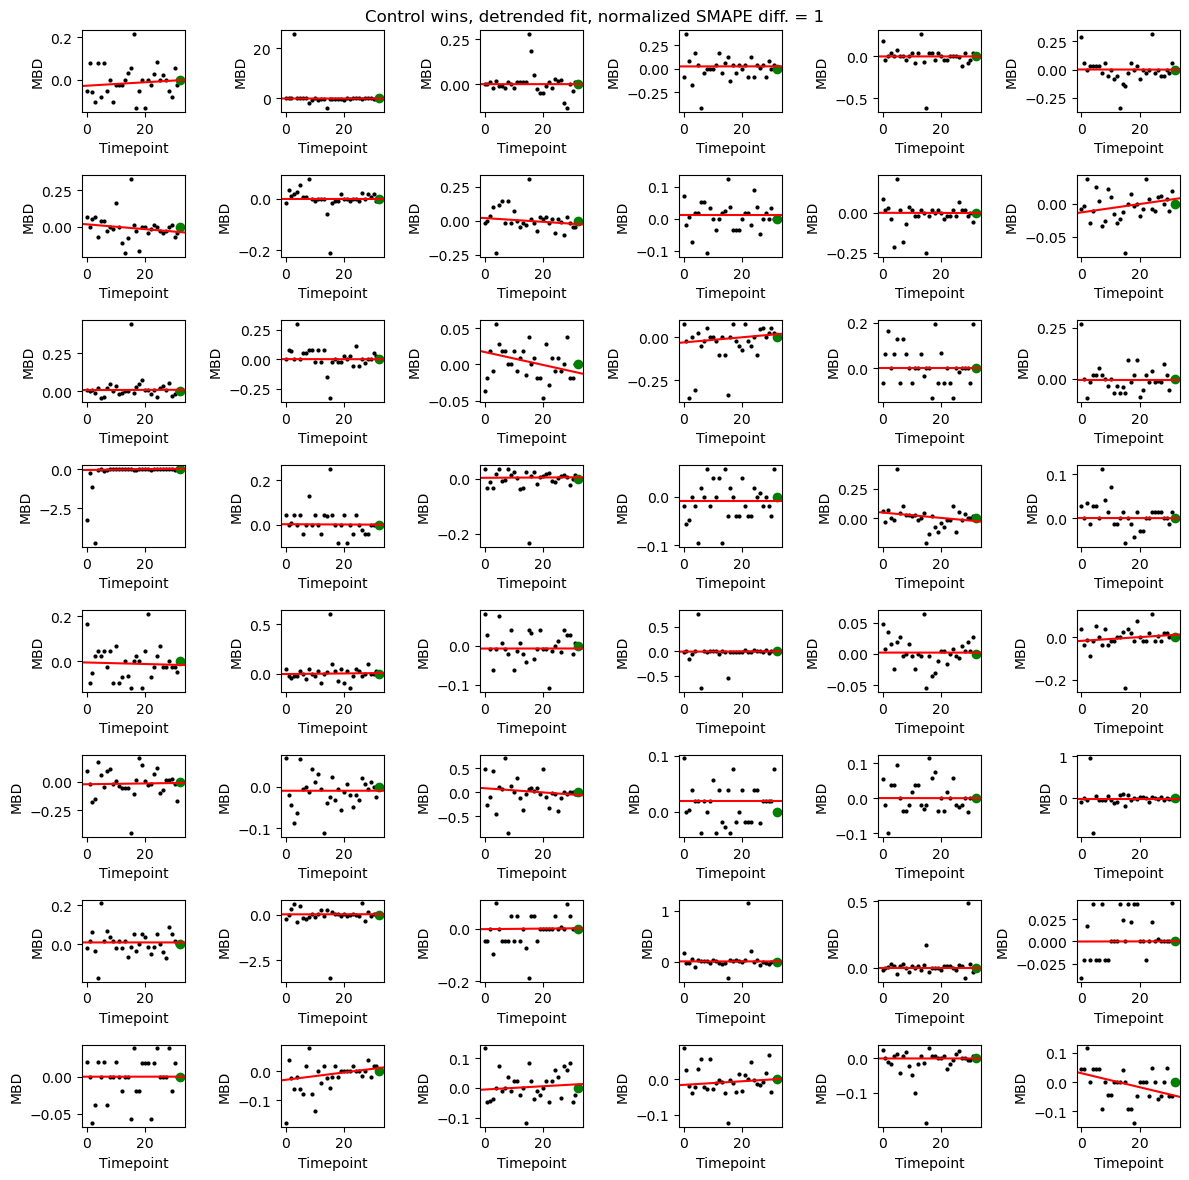

In [31]:
plot_rows = 8
plot_cols = 6
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = control_wins.iloc[[plot_num]]
        detrended_MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        MBD_values = list(data_point['MBD_inputs'])[0]
        x_values = list(range(len(MBD_values)))

        ax[i,j].scatter(
            x_values,
            detrended_MBD_values,
            color='black',
            s=4
        )

        ax[i,j].scatter(
            (x_values[-1] + 1),
            (data_point['MBD_actual'] - MBD_values[-1]),
            color='green'
        )

        detrended_ss = stats.siegelslopes(detrended_MBD_values, x_values)
        
        # Recover slope and intercept
        slope = detrended_ss[0]
        intercept = detrended_ss[1]

        ax[i,j].axline(
            [x_values[0], (intercept + slope * x_values[0])],
            [x_values[-1], (intercept + slope * x_values[-1])],
            color='red'
        )
        
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Control wins, detrended fit, normalized SMAPE diff. = 1')
plt.tight_layout()

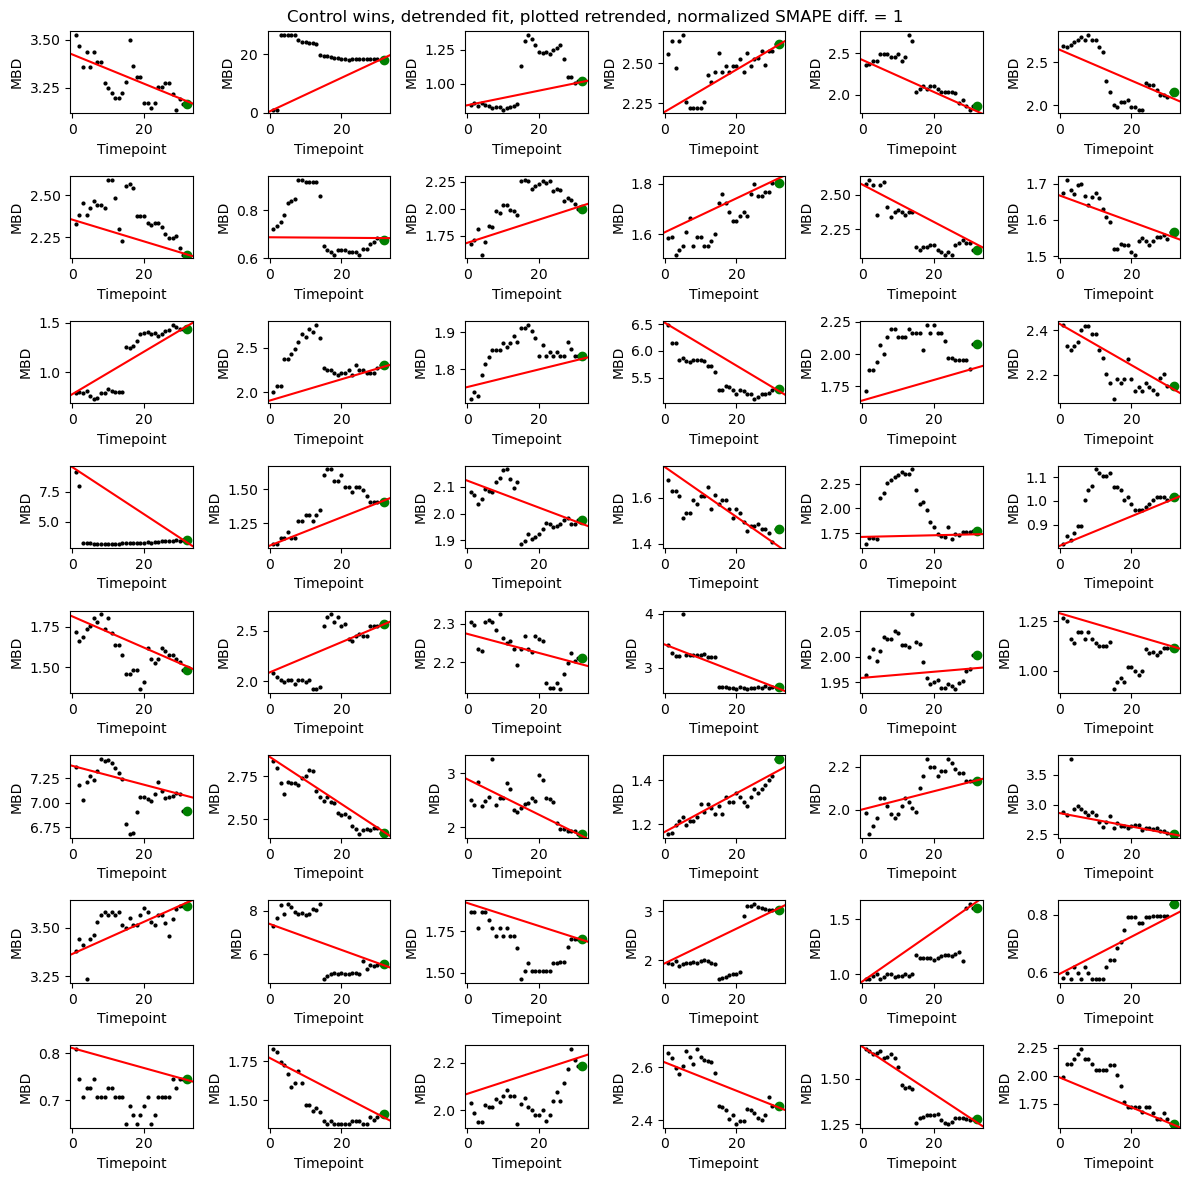

In [32]:
plot_rows = 8
plot_cols = 6
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = control_wins.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]
        detrended_MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        x_values = list(range(len(MBD_values)))

        ax[i,j].scatter(
            x_values[1:],
            MBD_values[1:],
            color='black',
            s=4
        )

        ax[i,j].scatter(
            (x_values[-1] + 1),
            data_point['MBD_actual'],
            color='green'
        )

        detrended_ss = stats.siegelslopes(detrended_MBD_values, x_values)
        
        # Recover slope and intercept
        slope = detrended_ss[0]
        intercept = detrended_ss[1]

        ax[i,j].axline(
            [x_values[1], (intercept + slope * x_values[0]) + MBD_values[0]],
            [x_values[-1], (intercept + slope * x_values[-1])+ MBD_values[-2]],
            color='red'
        )
        
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Control wins, detrended fit, plotted retrended, normalized SMAPE diff. = 1')
plt.tight_layout()

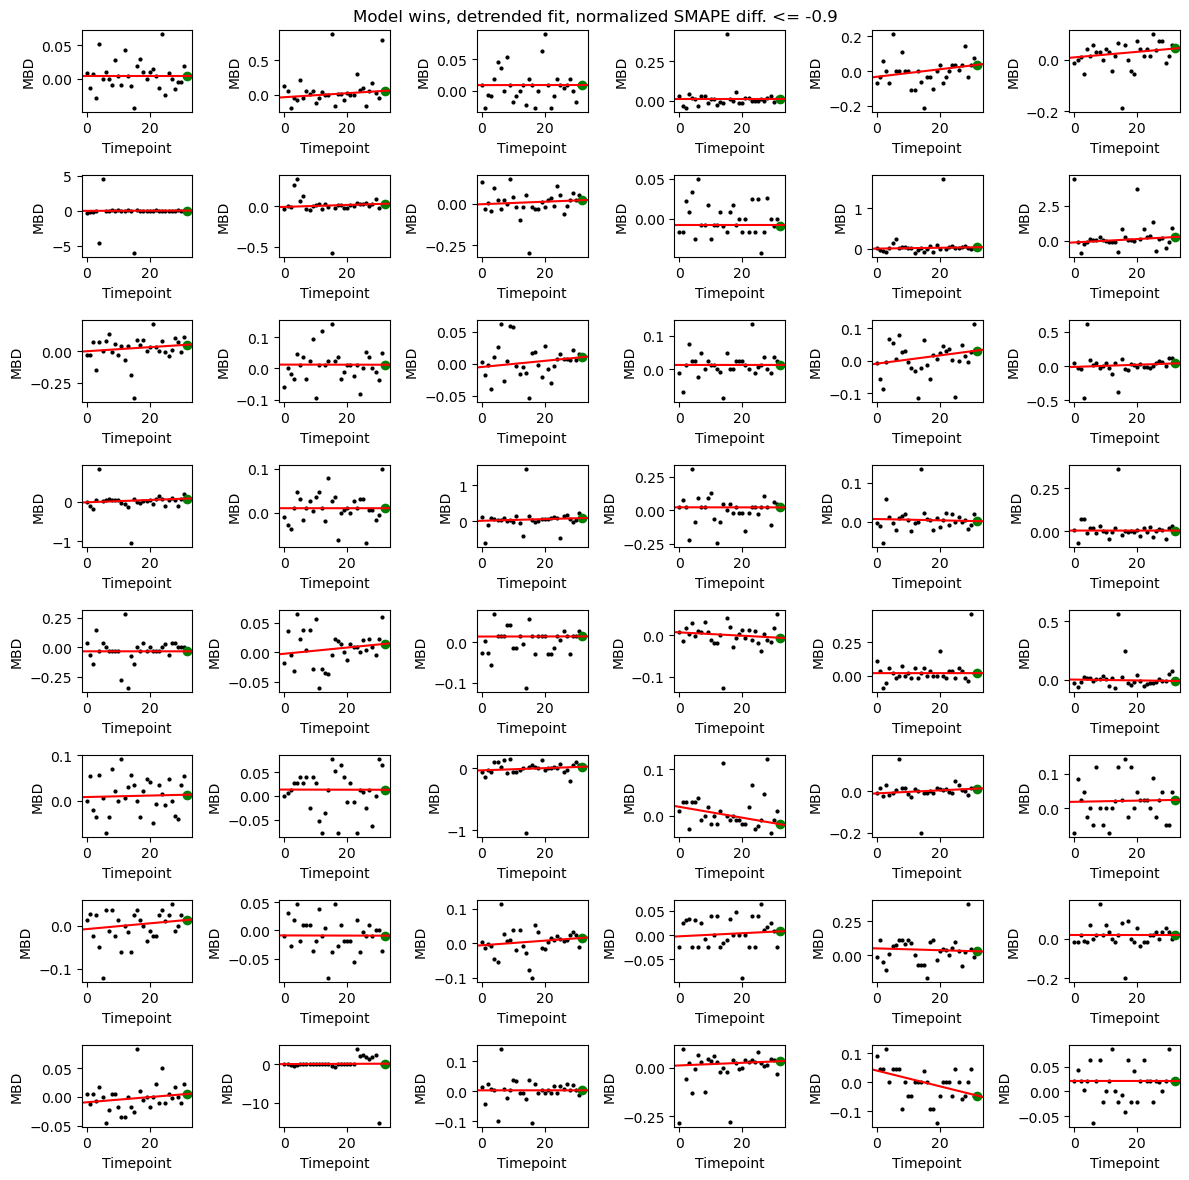

In [33]:
plot_rows = 8
plot_cols = 6
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = model_wins.iloc[[plot_num]]
        detrended_MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        MBD_values = list(data_point['MBD_inputs'])[0]
        x_values = list(range(len(MBD_values)))

        ax[i,j].scatter(
            x_values,
            detrended_MBD_values,
            color='black',
            s=4
        )

        ax[i,j].scatter(
            (x_values[-1] + 1),
            (data_point['MBD_actual'] - MBD_values[-1]),
            color='green'
        )

        detrended_ss = stats.siegelslopes(detrended_MBD_values, x_values)
        
        # Recover slope and intercept
        slope = detrended_ss[0]
        intercept = detrended_ss[1]

        ax[i,j].axline(
            [x_values[0], (intercept + slope * x_values[0])],
            [x_values[-1], (intercept + slope * x_values[-1])],
            color='red'
        )
        
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Model wins, detrended fit, normalized SMAPE diff. <= -0.9')
plt.tight_layout()

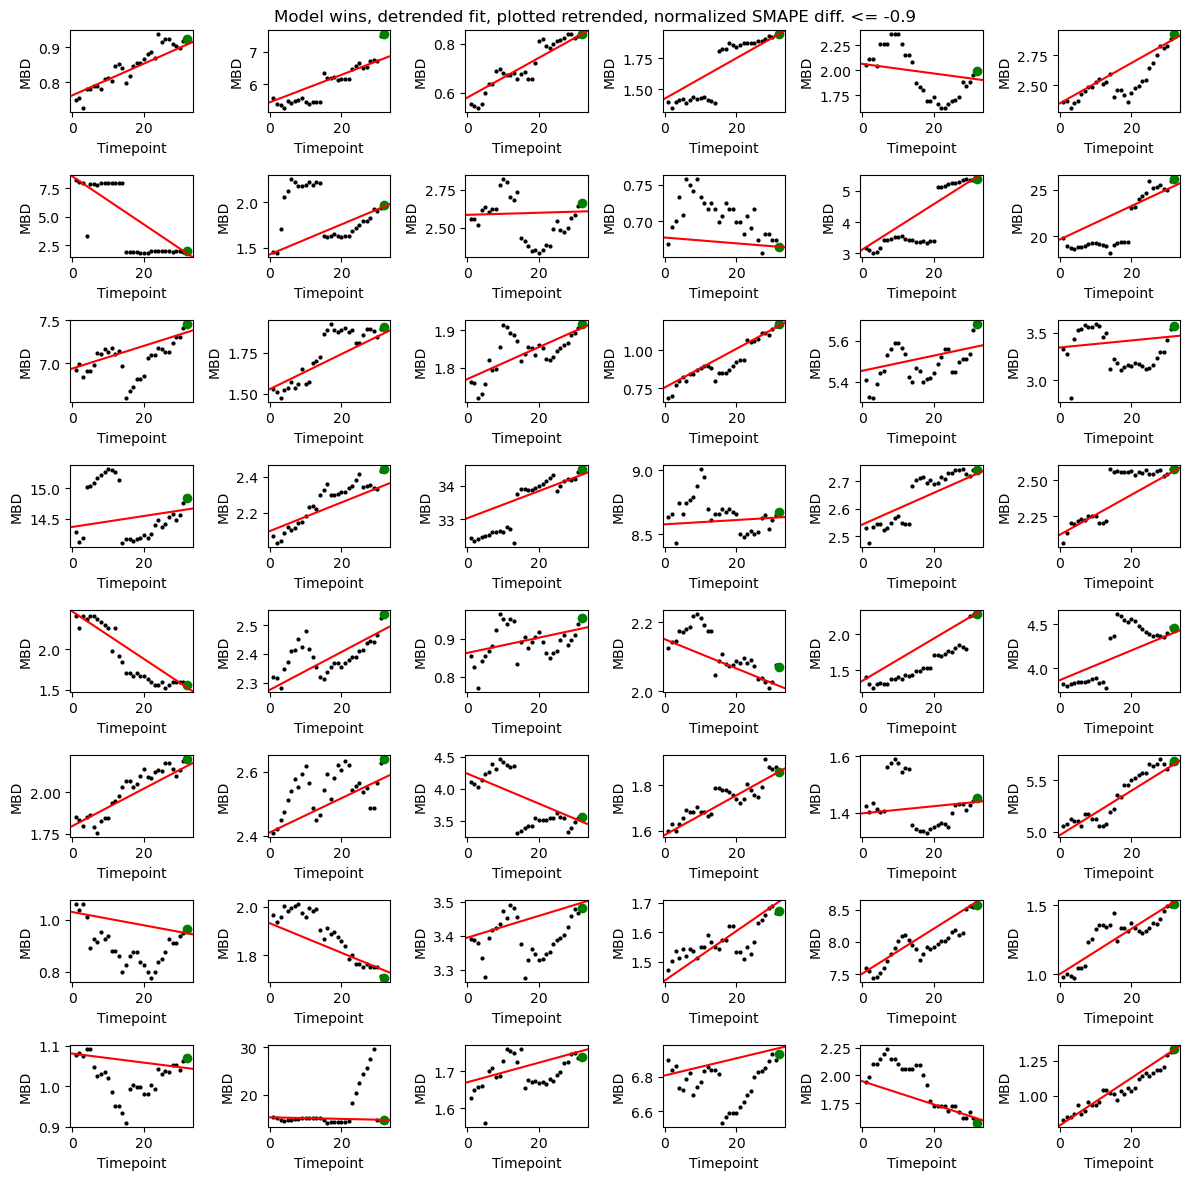

In [34]:
plot_rows = 8
plot_cols = 6
plot_num = 0

fig, ax = plt.subplots(plot_rows, plot_cols, figsize=(12,12))

for i in range(plot_rows):
    for j in range(plot_cols):

        data_point = model_wins.iloc[[plot_num]]
        MBD_values = list(data_point['MBD_inputs'])[0]
        detrended_MBD_values = list(data_point['detrended_MBD_inputs'])[0]
        x_values = list(range(len(MBD_values)))

        ax[i,j].scatter(
            x_values[1:],
            MBD_values[1:],
            color='black',
            s=4
        )

        ax[i,j].scatter(
            (x_values[-1] + 1),
            data_point['MBD_actual'],
            color='green'
        )


        detrended_ss = stats.siegelslopes(detrended_MBD_values, x_values)
        
        # Recover slope and intercept
        slope = detrended_ss[0]
        intercept = detrended_ss[1]

        ax[i,j].axline(
            [x_values[1], (intercept + slope * x_values[0]) + MBD_values[0]],
            [x_values[-1], (intercept + slope * x_values[-1])+ MBD_values[-2]],
            color='red'
        )
        
        ax[i,j].set_xlabel(f'Timepoint')
        ax[i,j].set_ylabel(f'MBD')

        plot_num += 1

plt.suptitle('Model wins, detrended fit, plotted retrended, normalized SMAPE diff. <= -0.9')
plt.tight_layout()

First thing that jumps out - many of the above plots are duplicates. This is expected, the appear in the dataset multiple times because our bootstrapping procedure uses resampling. However, Nothing jumps out as to why the control seems to absolutely nail it on these examples. Many of the plots do look as if they get flatter toward the end of time time range, but they clearly all don't go completely flat. One idea these plots give me: let's try looking at just the last fit residual of last few fit residuals from the regression model. The model is looking at all of the data, and many of these plots look like even a 'good' regression line is probably pretty off the mark at the right edge of the plot.

In [74]:
def get_residuals(col_index, model_data):

    # Holder for results
    result = []

    # Loop on dataframe rows
    for i in range(len(model_data)):

        # Get data for this row
        data_point = model_data[i]

        # Get model input data
        input_data = data_point[col_index['MBD_inputs']]
        detrended_input_data = data_point[col_index['detrended_MBD_inputs']]

        # Temporary holder for this row's data
        row_result = []

        # Get one point values 
        SMAPE_diff_value = data_point[col_index['SMAPE_diff']]
        SMAPE_value = data_point[col_index['detrended_SMAPE_values']]
        prediction = data_point[col_index['detrended_MBD_predictions']]

        # Start new row with one point values
        row_result = [SMAPE_diff_value, SMAPE_value, prediction]

        # Add input data to row. Note: since we need the i - 1th data
        # point to un-detrend the predictions, we can't use the 
        # first datapoint from each input
        row_result.extend(input_data[-3:])
        row_result.extend(detrended_input_data[-3:])

        # Fit Theil-Sen
        detrended_ts = stats.theilslopes(detrended_input_data, list(range(len(detrended_input_data))))

        # Recover slope and intercept
        slope = detrended_ts[0]
        intercept = detrended_ts[1]

        # Get y values fitted on the detrended data, and reconstruct
        # MBD prediction, use that to get the residual
        i = 0

        residuals = []
        normalized_residuals = []

        for i in range(len(detrended_input_data[1:])):

            # Get the detrended model's prediction for this point
            detrended_model_y = intercept + slope * i

            # Recover the MBD value for this prediction
            prior_value_index = i - 1
            model_y = detrended_model_y + input_data[prior_value_index]

            # Calculate the residual relative to the input
            residual = abs(model_y - input_data[i])
            
            if (residual == 0) and (input_data[i] == 0):
                normalized_residual = 0
            else:
                normalized_residual = (residual - input_data[i]) / (residual + input_data[i]) + 1
            
            # Collect
            residuals.append(residual)
            normalized_residuals.append(normalized_residual)

        # Extend row results with the last 3 residuals
        row_result.extend(residuals[-3:])
        row_result.extend(normalized_residuals[-3:])

        # Once row is complete, add it to results
        result.append(row_result)

    return np.array(result)

In [75]:
# Extract column names
colnames = model_data_df.columns

# Make numbered index dict for numpy array so we can easily track columns
col_index = {}

for i in range(len(colnames)):
    col_index[colnames[i]] = i

# Convert to numpy
model_data = model_data_df.to_numpy()

chunks = np.array_split(model_data, params.n_cpus)

for chunk in chunks:
    print(f'Chunk size: {len(chunk)}, chunk type: {type(chunk)}')

print()
print(f'{len(chunks)} chunks')
print()
print(f'Chunk column index: {col_index}')

Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>

18 chunks

In [76]:
pool, result_objects = parallel_funcs.start_multiprocessing_pool()

# Loop on dataframe chunks
for chunk in chunks:

    print(f'Input is {type(chunk)}, with {len(chunk)} rows.')

    result = pool.apply_async(get_residuals,
        args = (col_index, chunk)
    )

    # Add result to collection
    result_objects.append(result)

# Collect results
residuals = []
results = [result.get() for result in result_objects]
print()
print(f'Results are {type(results)}, with length {len(results)}.')
print(f'Result element is {type(results[0])}, with shape {results[0].shape}')

# Concatenate results
residuals = np.vstack(results)
print(f'Output is {type(residuals)}, with shape {residuals.shape}.')

Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.

Results are <class 'list'>, with length 18.
Result element is <class 'numpy.ndarr

In [77]:
residuals_col_names = ['SMAPE_diff_values','SMAPE_values','detrended_MBD_predictions']

# Add sequentially numbered input names
for i in range(3):
    residuals_col_names.append(f'input_{i}')

for i in range(3):
    residuals_col_names.append(f'detrended_input_{i}')

# Add sequentially numbered residuals
for i in range(3):
    residuals_col_names.append(f'residual_{i}')

# Add sequentially numbered residual fractions
for i in range(3):
    residuals_col_names.append(f'normalized_residual_{i}')

print(residuals_col_names)

['SMAPE_diff_values', 'SMAPE_values', 'detrended_MBD_predictions', 'input_0', 'input_1', 'input_2', 'detrended_input_0', 'detrended_input_1', 'detrended_input_2', 'residual_0', 'residual_1', 'residual_2', 'normalized_residual_0', 'normalized_residual_1', 'normalized_residual_2']


In [78]:
residuals_df = pd.DataFrame(residuals, columns=residuals_col_names)
residuals_df.head()

,SMAPE_diff_values,SMAPE_values,detrended_MBD_predictions,input_0,input_1,input_2,detrended_input_0,detrended_input_1,detrended_input_2,residual_0,residual_1,residual_2,normalized_residual_0,normalized_residual_1,normalized_residual_2
0,0.000000,0.042553,1.669086,1.741655,1.741655,1.669086,0.000000,0.000000,-0.072569,0.430795,0.004988,0.005357,0.396599,0.005712,0.006133
1,-0.171015,0.005466,1.207765,1.195703,1.186362,1.205044,0.018683,-0.009341,0.018683,0.026483,0.017018,0.011129,0.044010,0.028067,0.018587
2,-0.408537,0.006964,3.137806,3.044281,2.993030,3.064781,0.225502,-0.051251,0.071751,0.005720,0.168137,0.110200,0.004050,0.104680,0.071023
3,0.013229,0.021617,1.232096,1.231401,1.231401,1.231401,0.000000,0.000000,0.000000,0.017372,0.008944,0.009607,0.027823,0.014422,0.015482
4,0.000000,0.035714,1.625296,1.595745,1.595745,1.625296,0.000000,0.000000,0.029551,0.029551,0.000000,0.000000,0.036364,0.000000,0.000000


In [79]:
residuals_df['residual_2'].describe()

count    270000.000000
mean          0.057896
std           1.809821
min           0.000000
25%           0.006974
50%           0.018465
75%           0.038910
max         214.256567
Name: residual_2, dtype: float64

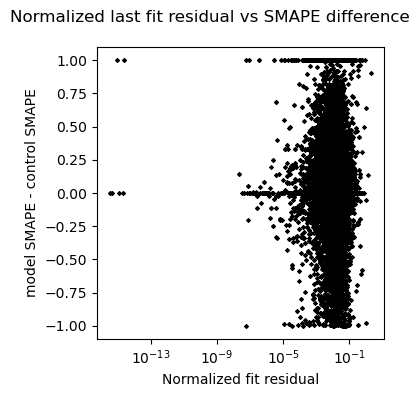

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    residuals_df['normalized_residual_2'],
    residuals_df['SMAPE_diff_values'],
    color='black',
    s=2
)

ax.set_xlabel('Normalized fit residual')
ax.set_ylabel('model SMAPE - control SMAPE')
ax.set_xscale('log')

plt.suptitle(f'Normalized last fit residual vs SMAPE difference')
plt.tight_layout()

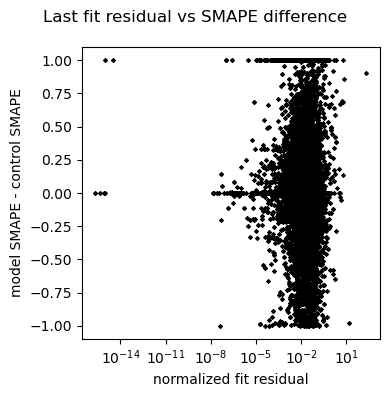

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    residuals_df['residual_2'],
    residuals_df['SMAPE_diff_values'],
    color='black',
    s=2
)

ax.set_xlabel('fit residual')
ax.set_ylabel('model SMAPE - control SMAPE')
ax.set_xscale('log')

plt.suptitle(f'Last fit residual vs SMAPE difference')
plt.tight_layout()

OK, so - I'm about out of ideas here. I can't find a strong correlation or a meaningful proxy for the relative performance of the control vs regression model. I think part of the issue here is that the amounts the regression model is missing by are on the order of the 'noise' in most of the timeseries. It's basically up to chance if the model wins or the regression wins:

In [85]:
model_wins = len(model_data_df[model_data_df['SMAPE_diff'] < 0])
control_wins = len(model_data_df[model_data_df['SMAPE_diff'] > 0])

print(f'Model wins: {(model_wins / len(model_data_df))*100:.0f}%')
print(f'Control wins: {(control_wins / len(model_data_df))*100:.0f}%')

Model wins: 38%
Control wins: 49%


...and the rest are ties. Which by itself is kind of surprising to me. Anyway, I don't think there is good way to predict what model will win from the input sequence alone.

One last thing I want to try before moving on - I did notice on the large sets of scatter plots showing the input, true target value and regression line, that sometimes the regression is over or under shooting the prediction due to the effect of points earlier in the timeseries. It is true that longer model orders win overall, but if you look at the boxplots at the beginning of the notebook there is overlap between the score distributions for the model orders. For example, some order 16 scores are better than some order 32 scores. The question is, are their specific point where a lower order model actually does better than a longer one, and again, can we identify them from the input data? Let's take a look.

In [86]:
data_df.head()

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual
0,0,control,4,0.007134,0.007010,1.197231,1.180416,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
1,0,OLS,4,0.016566,0.010621,1.208577,1.176161,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
2,0,TS,4,0.013222,0.014331,1.204542,1.171805,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
3,0,Seigel,4,0.010597,0.018923,1.201384,1.166437,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872
4,0,Ridge,4,0.016056,0.007232,1.207961,1.180154,"[1.1913542, 1.2168832, 1.2140466, 1.1972311]","[0.0056730999999998755, 0.025529000000000135, ...",1.18872


In [97]:
seigel32_df = data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)].copy()
seigel32_df.reset_index(inplace = True, drop=True)

seigel16_df = data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)].copy()
seigel16_df.reset_index(inplace = True, drop=True)

seigel8_df = data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 32)].copy()
seigel8_df.reset_index(inplace = True, drop=True)

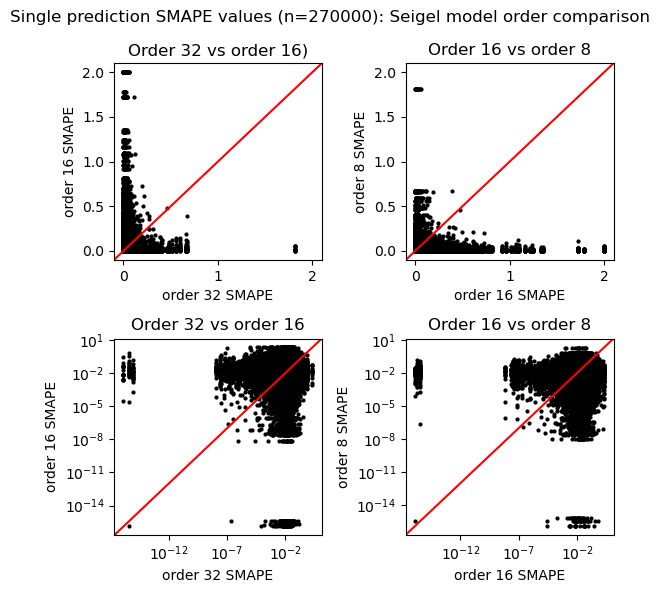

In [98]:
fig, ax = plt.subplots(2, 2, figsize=(6,6))

ax[0,0].scatter(
    seigel32_df['detrended_SMAPE_values'],
    seigel16_df['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[0,0].axline([0,0], [2,2], color='red')

ax[0,0].set_xlabel('order 32 SMAPE')
ax[0,0].set_ylabel('order 16 SMAPE')
ax[0,0].set_title('Order 32 vs order 16')

ax[0,1].scatter(
    seigel16_df['detrended_SMAPE_values'],
    seigel8_df['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[0,1].axline([0,0], [2,2], color='red')

ax[0,1].set_xlabel('order 16 SMAPE')
ax[0,1].set_ylabel('order 8 SMAPE')
ax[0,1].set_title('Order 16 vs order 8')

ax[1,0].scatter(
    seigel32_df['detrended_SMAPE_values'],
    seigel16_df['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[1,0].axline([0,0], [2,2], color='red')

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('order 32 SMAPE')
ax[1,0].set_ylabel('order 16 SMAPE')
ax[1,0].set_title('Order 32 vs order 16')
# ax[1,0].set_xlim([10**-8,10])
# ax[1,0].set_ylim([10**-8,10])

ax[1,1].scatter(
    seigel16_df['detrended_SMAPE_values'],
    seigel8_df['detrended_SMAPE_values'],
    color='black',
    s=4
)

ax[1,1].axline([0,0], [2,2], color='red')

ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('order 16 SMAPE')
ax[1,1].set_ylabel('order 8 SMAPE')
ax[1,1].set_title('Order 16 vs order 8')
# ax[1,1].set_xlim([10**-8,10])
# ax[1,1].set_ylim([10**-8,10])

n = len(data_df[(data_df['model_type'] == 'Seigel') & (data_df['model_order'] == 16)]['detrended_SMAPE_values'])
plt.suptitle(f'Single prediction SMAPE values (n={n}): Seigel model order comparison')
plt.tight_layout()

Yep - OK! Part of me was almost hoping that this would not look promising so we could move on, but I think it's worth checking out. From the pairwise comparison of models, it's apparent that most points are scored similarly between each order pair, but there are points which score well with one order and badly with another and vice versa. Question is, what to do with this information?

I can think of two options. First, we could use several models of different orders and a weighted average to score each point. This approach has the benefit of avoiding the need to decide what model to use. The other approach is to see if we can come up with a way to pick what model to use based on the input data. Same problem as before.

Let's try our intuitive thought about the last residual or residuals again.

In [99]:
seigel32_df['SMAPE_diff'] = (seigel32_df['detrended_SMAPE_values'] - seigel16_df['detrended_SMAPE_values']) / (seigel16_df['detrended_SMAPE_values'] + seigel32_df['detrended_SMAPE_values'])
seigel32_df['prediction_diff'] = (seigel32_df['detrended_MBD_predictions'] - seigel16_df['detrended_MBD_predictions']) / (seigel16_df['detrended_MBD_predictions'] + seigel32_df['detrended_MBD_predictions'])

,sample,model_type,model_order,SMAPE_values,detrended_SMAPE_values,MBD_predictions,detrended_MBD_predictions,MBD_inputs,detrended_MBD_inputs,MBD_actual,SMAPE_diff,prediction_diff
0,0,Seigel,32,0.280631,0.042553,2.310191,1.669086,"[1.6087517, 1.6087517, 1.6372796, 1.952141, 2....","[-0.3217502000000001, 0.0, 0.02852790000000005...",1.741655,-0.122577,0.215131
1,0,Seigel,32,0.037810,0.005466,1.169322,1.207765,"[1.0450745, 1.0541621, 1.0619793, 1.0345143, 1...","[0.036350399999999894, 0.009087600000000196, 0...",1.214386,-0.043128,-0.621327
2,0,Seigel,32,0.015627,0.006964,3.067713,3.137806,"[1.4759005, 1.4139746, 1.4567621, 1.4464304, 1...","[0.11353080000000015, -0.06192590000000009, 0....",3.116031,-0.300782,0.306525
3,0,Seigel,32,0.031594,0.021617,1.244452,1.232096,"[1.1312218, 1.1060835, 1.1252813, 1.0752689, 1...","[-0.10055299999999989, -0.025138300000000058, ...",1.205747,0.399913,-0.852360
4,0,Seigel,32,0.025929,0.035714,1.728645,1.625296,"[1.2269939, 1.2269939, 1.2099214, 1.2401694, 1...","[0.0, 0.0, -0.017072500000000046, 0.0302480000...",1.684397,0.843005,-0.549742


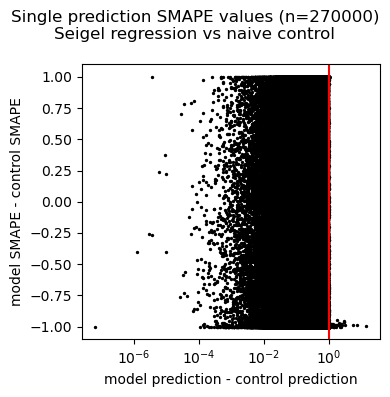

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    abs(seigel32_df['prediction_diff']),
    seigel32_df['SMAPE_diff'],
    color='black',
    s=2
)

ax.axline([1,-1.00], [1,1.00], color='red')

ax.set_xlabel('model prediction - control prediction')
ax.set_ylabel('model SMAPE - control SMAPE')

ax.set_xscale('log', base=10)

plt.suptitle(f'Single prediction SMAPE values (n={n})\nSeigel regression vs naive control')
plt.tight_layout()

Again, we have a tiny wisp of points where one model clearly dominates if the prediction difference is above ~1. But it's the order 32 model, so knowing that does not help.

In [113]:
# Extract column names
colnames = seigel32_df.columns

# Make numbered index dict for numpy array so we can easily track columns
col_index = {}

for i in range(len(colnames)):
    col_index[colnames[i]] = i

# Convert to numpy
model_data = seigel32_df.to_numpy()

chunks = np.array_split(model_data, params.n_cpus)

for chunk in chunks:
    print(f'Chunk size: {len(chunk)}, chunk type: {type(chunk)}')

print()
print(f'{len(chunks)} chunks')
print()
print(f'Chunk column index: {col_index}')

Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>
Chunk size: 15000, chunk type: <class 'numpy.ndarray'>

18 chunks

In [114]:
pool, result_objects = parallel_funcs.start_multiprocessing_pool()

# Loop on dataframe chunks
for chunk in chunks:

    print(f'Input is {type(chunk)}, with {len(chunk)} rows.')

    result = pool.apply_async(get_residuals,
        args = (col_index, chunk)
    )

    # Add result to collection
    result_objects.append(result)

# Collect results
residuals = []
results = [result.get() for result in result_objects]
print()
print(f'Results are {type(results)}, with length {len(results)}.')
print(f'Result element is {type(results[0])}, with shape {results[0].shape}')

# Concatenate results
residuals = np.vstack(results)
print(f'Output is {type(residuals)}, with shape {residuals.shape}.')

Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.
Input is <class 'numpy.ndarray'>, with 15000 rows.

Results are <class 'list'>, with length 18.
Result element is <class 'numpy.ndarr

In [115]:
residuals_col_names = ['SMAPE_diff_values','SMAPE_values','detrended_MBD_predictions']

# Add sequentially numbered input names
for i in range(3):
    residuals_col_names.append(f'input_{i}')

for i in range(3):
    residuals_col_names.append(f'detrended_input_{i}')

# Add sequentially numbered residuals
for i in range(3):
    residuals_col_names.append(f'residual_{i}')

# Add sequentially numbered residual fractions
for i in range(3):
    residuals_col_names.append(f'normalized_residual_{i}')

print(residuals_col_names)

['SMAPE_diff_values', 'SMAPE_values', 'detrended_MBD_predictions', 'input_0', 'input_1', 'input_2', 'detrended_input_0', 'detrended_input_1', 'detrended_input_2', 'residual_0', 'residual_1', 'residual_2', 'normalized_residual_0', 'normalized_residual_1', 'normalized_residual_2']


In [116]:
residuals_df = pd.DataFrame(residuals, columns=residuals_col_names)
residuals_df.head()

,SMAPE_diff_values,SMAPE_values,detrended_MBD_predictions,input_0,input_1,input_2,detrended_input_0,detrended_input_1,detrended_input_2,residual_0,residual_1,residual_2,normalized_residual_0,normalized_residual_1,normalized_residual_2
0,-0.122577,0.042553,1.669086,1.741655,1.741655,1.669086,0.000000,0.000000,-0.072569,0.430795,0.004988,0.005357,0.396599,0.005712,0.006133
1,-0.043128,0.005466,1.207765,1.195703,1.186362,1.205044,0.018683,-0.009341,0.018683,0.026483,0.017018,0.011129,0.044010,0.028067,0.018587
2,-0.300782,0.006964,3.137806,3.044281,2.993030,3.064781,0.225502,-0.051251,0.071751,0.005720,0.168137,0.110200,0.004050,0.104680,0.071023
3,0.399913,0.021617,1.232096,1.231401,1.231401,1.231401,0.000000,0.000000,0.000000,0.017372,0.008944,0.009607,0.027823,0.014422,0.015482
4,0.843005,0.035714,1.625296,1.595745,1.595745,1.625296,0.000000,0.000000,0.029551,0.029551,0.000000,0.000000,0.036364,0.000000,0.000000


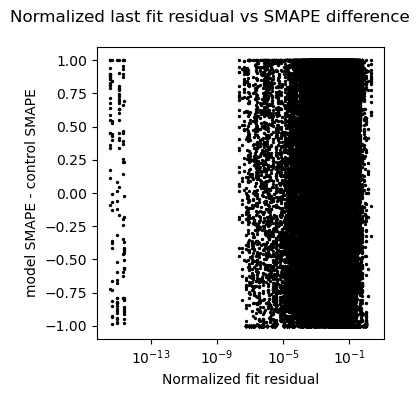

In [117]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    residuals_df['normalized_residual_2'],
    residuals_df['SMAPE_diff_values'],
    color='black',
    s=2
)

ax.set_xlabel('Normalized fit residual')
ax.set_ylabel('model SMAPE - control SMAPE')
ax.set_xscale('log')

plt.suptitle(f'Normalized last fit residual vs SMAPE difference')
plt.tight_layout()

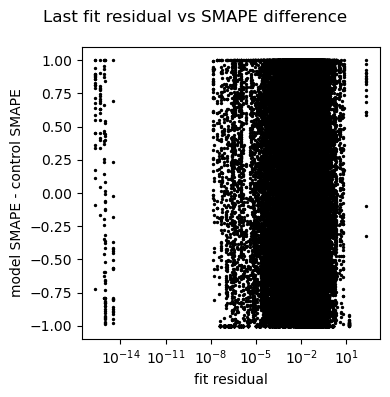

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))

ax.scatter(
    residuals_df['residual_2'],
    residuals_df['SMAPE_diff_values'],
    color='black',
    s=2
)

ax.set_xlabel('fit residual')
ax.set_ylabel('model SMAPE - control SMAPE')
ax.set_xscale('log')

plt.suptitle(f'Last fit residual vs SMAPE difference')
plt.tight_layout()

In [121]:
seigel32_wins = len(seigel32_df[seigel32_df['SMAPE_diff'] < 0])
seigel16_wins = len(seigel32_df[seigel32_df['SMAPE_diff'] > 0])

print(f'Order 32 wins: {(seigel32_wins / len(seigel32))*100:.0f}%')
print(f'Order 16 wins: {(seigel16_wins / len(seigel32))*100:.0f}%')

Order 32 wins: 60%
Order 16 wins: 40%
